In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import sklearn.datasets
#import sklearn.feature_extraction.text
#import sklearn.preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import scipy.sparse
import vectorizers
import vectorizers.transformers
import seaborn as sns
import igraph as ig
from scipy.sparse import vstack
sns.set()
import umap
import umap.plot
umap.plot.output_notebook()
from bokeh.plotting import show
from collections import Counter

import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors


Loading BokehJS ...

In [2]:
## Datasets



In [3]:
dataset = 'REDDIT-BINARY'
datadir = '../Data/'+dataset+'/'+dataset

fn_graph_label = datadir+'.graph_labels'
## read graph labels
with open(fn_graph_label) as f:
    graph_labels = [int(x.strip()) for x in f.readlines()]


### read in embeddings

Todo: something nicer here
    

In [4]:
import pickle

fn = 'Results/expander_'+dataset+'.pkl'
with open(fn,'rb') as fp:
    expand_matrix, expand_matrix_norm, expand_matrix_rec, expand_matrix_svd = pickle.load(fp)

fn = 'Results/walks_'+dataset+'.pkl'
with open(fn,'rb') as fp:
    walks_matrix, walks_matrix_norm = pickle.load(fp)

Probes=[]
for d in np.arange(4,21,4):
    with open('Results/probes_'+str(d)+'_'+dataset+'.pkl','rb') as fp:
        Probes.append(pickle.load(fp))


In [5]:
def cross_validate(model, data, labels, n_splits=20, test_ratio=0.1, random_seed=42):
    splitter = sklearn.model_selection.ShuffleSplit(
        n_splits=n_splits, test_size=test_ratio, random_state=random_seed
    )
    result = sklearn.model_selection.cross_val_score(model, data, labels, cv=splitter)
    return result

def cross_validation_dataframe(model, data, labels, feature_sets, n_splits=20, test_ratio=0.1, random_seed=42):
    dfs = []
    for feature_space_name, feature_space in feature_sets.items():
        cv_scores = cross_validate(model, feature_space, labels, n_splits, test_ratio, random_seed)
        feature_df = pd.DataFrame(
            {
                "run" : np.arange(n_splits), 
                "Embedding" : feature_space_name,
                "Model" : model.__repr__().split("(")[0],
                "Accuracy" : cv_scores,
            }
        )
        dfs.append(feature_df)
    return pd.concat(dfs)

In [6]:
models_norm = [
    sklearn.neighbors.KNeighborsClassifier(metric="cosine", n_neighbors=9, weights="distance"),
    sklearn.ensemble.RandomForestClassifier(),
]
feature_sets_norm = {
    "Probes_4": Probes[0],
    "Probes_8": Probes[1],
    "Probes_12": Probes[2],
    "Probes_16": Probes[3],
    "Probes_20": Probes[4],
    "Walks": walks_matrix,
    "Expander": expand_matrix,
#    "Expander normalized":  expand_matrix_norm,
#    "Expander recursive": expand_matrix_rec,
    "Expander svd": expand_matrix_svd
}

In [7]:
%%time
results_norm = []
for model in models_norm:
    print(model)
    res = cross_validation_dataframe(
        model, 
        feature_sets_norm,
        graph_labels,
        feature_sets = feature_sets_norm
    )
    results_norm.append(res)

df_norm = pd.concat( results_norm )

KNeighborsClassifier(metric='cosine', n_neighbors=9, weights='distance')
RandomForestClassifier()
CPU times: user 3min 28s, sys: 2min 39s, total: 6min 7s
Wall time: 3min 16s


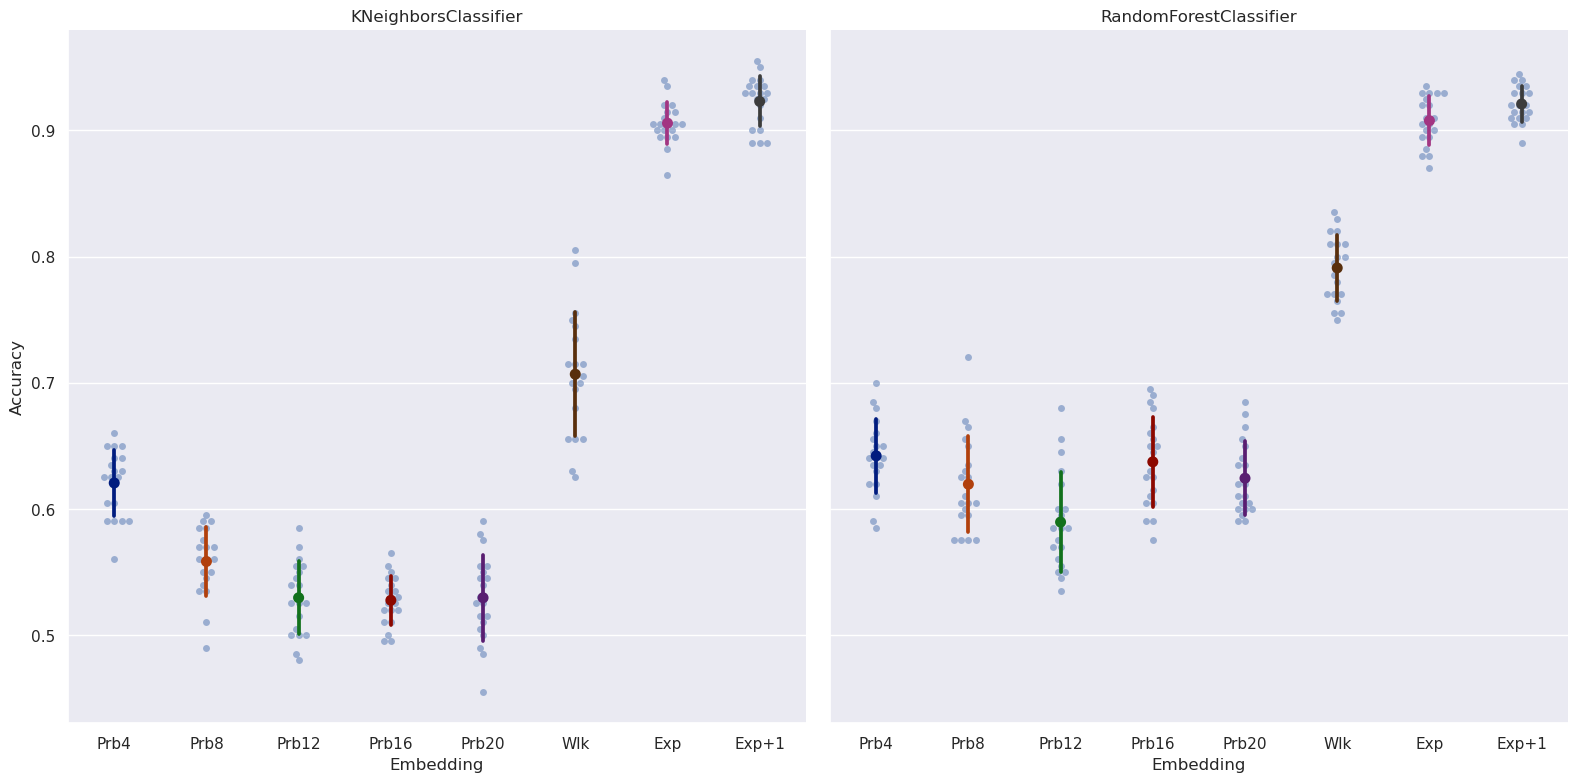

In [8]:
g = sns.catplot(
    kind="swarm", 
    x="Embedding", 
    y="Accuracy", 
    col="Model",
    col_wrap=2,
    data=df_norm, 
    height=8, 
    alpha=0.5,
    zorder=1,
)
g.map_dataframe(
    sns.pointplot, 
    x="Embedding", 
    y="Accuracy", 
    color="Model", 
    data=df_norm, 
    palette="dark",
    join=False,
    order=[
    "Probes_4",
    "Probes_8",
    "Probes_12",
    "Probes_16",
    "Probes_20",
    "Walks",
    "Expander",
#    "Expander normalized",
#    "Expander recursive",
    "Expander svd"       
    ],
    ci="sd",
    scale=0.9,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels([
        "Prb4",
        "Prb8",
        "Prb12",
        "Prb16",
        "Prb20",
        "Wlk",
        "Exp",
#        "ex(norm)",
#        "ex(+1)",
        "Exp+1"
    ]);
fn = 'Results/'+dataset+'.png'
g.savefig(fn)